In [1]:
import xarray as xr
import salem as sa
from cdo import *
from pathlib import Path
import matplotlib.pyplot as plt 
import darwin
import numpy as np
from maps_for_nnn import get_nino_index
from maps_for_nnn import plot_timeseries, get_mean_timeseries, mask_by_hgt_zone, define_hgt_zone

In [2]:
# constants
basepath = Path('/home/ben/data/GAR/rc_trop_ls_MM/')
variable = "prcp"
enso_event = "validation"
cdo = Cdo(returnNoneOnError=True,)
combinations = {
    "nina": ["2010", "2011"],
    "nino": ["2015", "2016"],
    "neutral": ["2016", "2017"],
    "validation": ["2022", "2023"],
}
nino12index = get_nino_index("nino1.2")
nino12index

<xarray.Dataset>
Dimensions:  (time: 1848)
Coordinates:
  * time     (time) datetime64[ns] 1870-01-01 1870-02-01 ... 2023-12-01
Data variables:
    value    (time) float64 -1.5 -0.96 -0.65 -0.32 -0.64 ... nan nan nan nan nan

In [3]:
def make_path(basepath: Path, year, variable):
    return basepath / f"rc_trop_ls_MM_d02km_d_2d_{variable}_{year}.nc"

def hydro_year(ifile1: Path, ifile2:Path, ofile=False):
    return cat_and_select(ifile2, ifile2, ofile)
    
def cat_and_select(
    ifile1: Path, 
    ifile2: Path, 
    ofile: bool=False, 
    start = None,
    end = None,
):
    variable = ifile1.stem.split("_")[-2]
    year1 = ifile1.stem.split("_")[-1]
    year2 = ifile2.stem.split("_")[-1]
    if not start:
        start = f"{year1}-11-01"
    if not end:
        end = f"{year2}-10-31"
    cdo = Cdo()
    return cdo.seldate(
        f"{start},{end}",
        input = f"-cat {ifile1} {ifile2}",
        ofile=ofile,
        returnXDataset = variable
    )

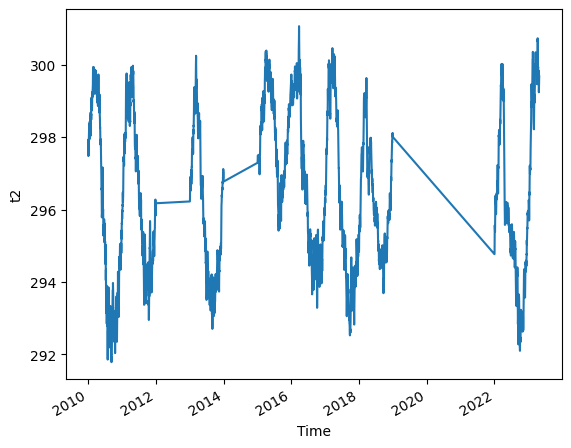

In [4]:
from maps_for_nnn import concatenate
from glob import glob
cdo = Cdo()
files = basepath.glob(f'rc_trop_ls_MM_d02km_d_2d_*t2*')
files = ' '.join(str(file) for file in files)
t2 = cdo.cat(input=files, ofile='test.nc', returnXDataset = 't2')
t2.t2.mean(dim=("south_north", "west_east")).plot()

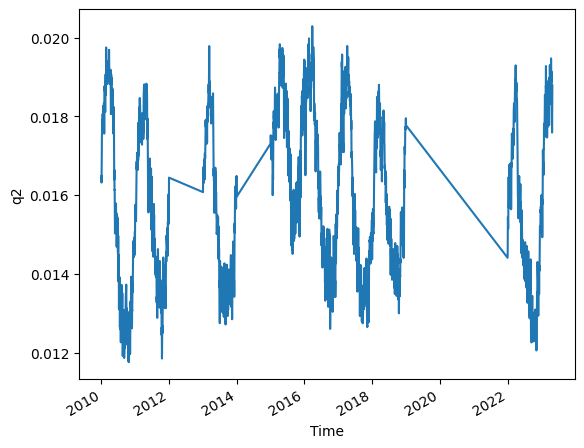

In [5]:
cdo = Cdo()
files = basepath.glob(f'rc_trop_ls_MM_d02km_d_2d_*q2*')
files = ' '.join(str(file) for file in files)
q2 = cdo.cat(input=files, ofile='test.nc', returnXDataset = 'q2')
q2.q2.mean(dim=("south_north", "west_east")).plot()

In [6]:
cdo = Cdo()
files = basepath.glob(f'rc_trop_ls_MM_d02km_d_2d_*prcp*')
files = ' '.join(str(file) for file in files)
prcp = cdo.mergetime(input=files, ofile='test.nc', returnXDataset = 'prcp')

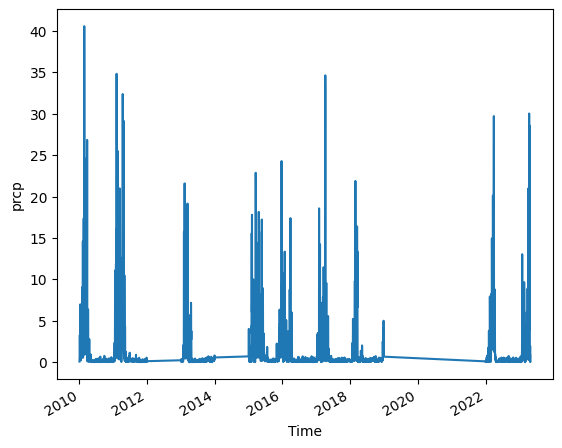

In [7]:
(prcp.prcp.mean(dim=("south_north", "west_east")) * 24).plot()

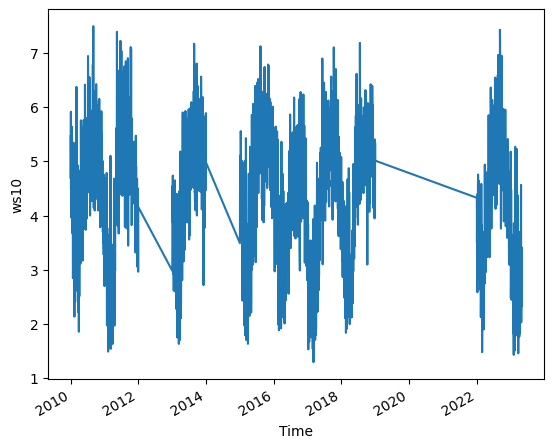

In [8]:
cdo = Cdo()
files = basepath.glob(f'rc_trop_ls_MM_d02km_d_2d_*ws10*')
files = ' '.join(str(file) for file in files)
ws10 = cdo.mergetime(input=files, ofile='test.nc', returnXDataset = 'ws10')
ws10.ws10.mean(dim=("south_north", "west_east")).plot()

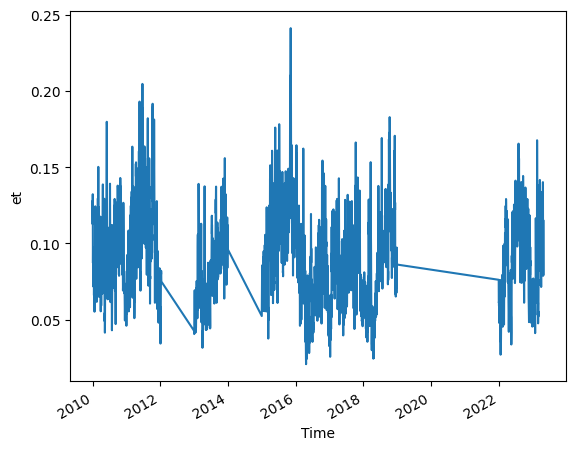

In [9]:
cdo = Cdo()
files = basepath.glob(f'rc_trop_ls_MM_d02km_d_2d_*et*')
files = ' '.join(str(file) for file in files)
et = cdo.mergetime(input=files, ofile='test.nc', returnXDataset = 'et')
et.et.mean(dim=("south_north", "west_east")).plot()

In [10]:
# nina_ = hydro_year(
#     make_path(basepath, combinations["nina"][0], variable),
#     make_path(basepath, combinations["nina"][1], variable),
# )
# nino = hydro_year(
#     make_path(basepath, combinations["nino"][0], variable),
#     make_path(basepath, combinations["nino"][1], variable),
# )
# neutral = hydro_year(
#     make_path(basepath, combinations["neutral"][0], variable),
#     make_path(basepath, combinations["neutral"][1], variable),
# )
validation = cat_and_select(
    make_path(basepath, combinations["validation"][0], variable),
    make_path(basepath, combinations["validation"][1], variable),
    start="2022-04-01",
    end="2023-03-31",
)
# nina = xr.concat([nina_, nino, neutral, validation], 'time')
# nino = nino.drop([np.datetime64('2016-02-29')], dim='time')

In [11]:
oceans = sa.read_shapefile(sa.get_demo_file('ne_50m_ocean.shp'),
                               cached=True)
# nina_land = nina_.salem.roi(shape=oceans, all_touched=False)
# neutral_land = neutral.salem.roi(shape=oceans, all_touched=False)
# nino_land = nino.salem.roi(shape=oceans, all_touched=False)
validation_land = validation.salem.roi(shape=oceans, all_touched=False)

/home/ben/.pyenv/versions/3.10.4/envs/darwin/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


In [12]:
def plot_map(ds, name, remove_boundaries=True, **kwargs):
    fig, ax = plt.subplots(figsize=(16,14), sharex=True, sharey=True, )
    if remove_boundaries:
        ds = ds.remove_boundaries(40)
    ds.plot_map(ax=ax, **kwargs)
    plt.savefig(f"rc_trop_ls_MM_{variable}_sum_map_{name}.png")
    plt.show()

In [15]:
from importlib import reload
reload(darwin)

plot_map_args = {
    "aggregation":"sum", 
    "save": True, 
    "stations": True, 
    "cbar": True, 
    "unit":'mm', 
    "cmap":'coolwarm', 
    # "vmax":1500
}

plot_map_args["vmax"] = 2500
plot_map_args["vmin"] = 0
plot_map_args["cmap"] = "YlGnBu"
diff = nina_.copy()
diff[variable].data = nino[variable].data - nina_[variable].data
diff.attrs = neutral.attrs
ds = darwin.Experiment(diff)
# plot_map(ds, name=enso_event, **plot_map_args)
plt.savefig(f"rc_trop_ls_MM_{variable}_sum_map_nino-nina.png")

NameError: name 'nina_' is not defined

Getting variable name translations
Getting variable name translations


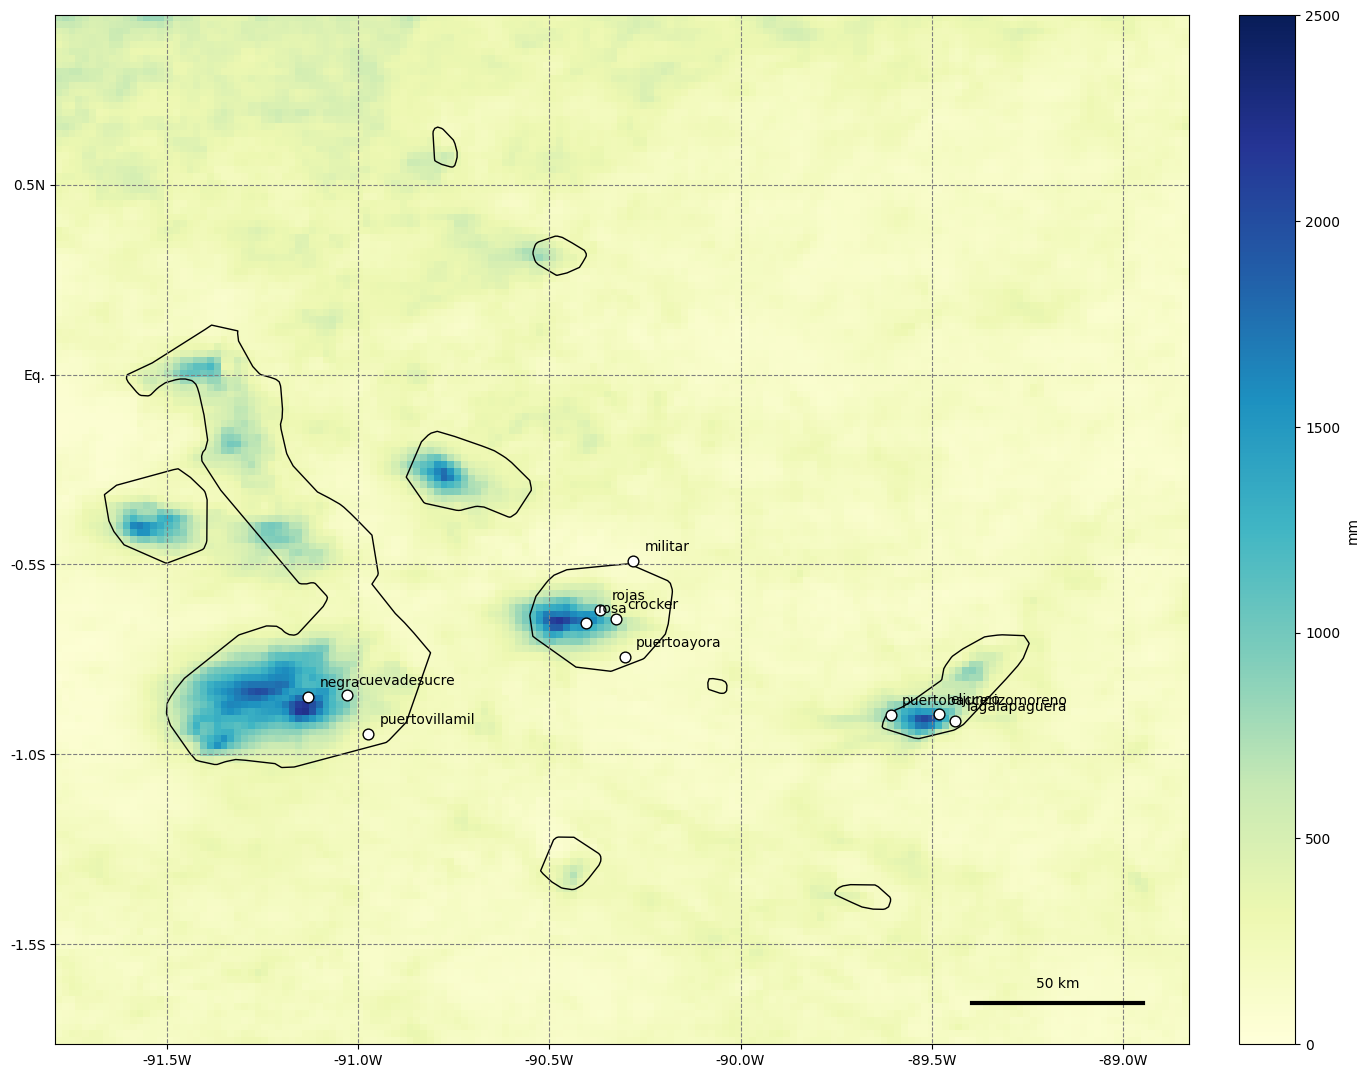

In [16]:
ds = darwin.Experiment(globals()[enso_event])
plot_map(ds, name=enso_event, **plot_map_args)
# plt.savefig(f"rc_trop_ls_MM_{variable}_sum_map_{enso_event}.png")

In [50]:
# fig = plt.figure(figsize=(12, 6))
# plt.plot(nina_land.time, (24 * nina_land.mean(dim=("west_east", "south_north")).cumsum()[variable]), label="La Nina - 2010/2011")
# plt.plot(nina_land.time, (24 * nino_land.mean(dim=("west_east", "south_north")).cumsum()[variable]), label="El Nino - 2015/2016")
# plt.plot(nina_land.time, (24 * neutral_land.mean(dim=("west_east", "south_north")).cumsum()[variable]), label="Neutral - 2016/2017")
# locs, labels = plt.xticks()
# plt.xticks(locs, ['11-01', '11-15', '12-01', '12-15', '01-01', '01-15', '02-01'])
# plt.grid()
# plt.legend()
# # plt.tight_layout()
# plt.ylabel(f"cumulative {variable} over land in mm")
# plt.savefig(f"rc_trop_ls_MM_{variable}_cumsum_line_nino-nina-neutral.png")
# plt.show()

In [51]:
# zonal classification by altitude
reload(darwin)
path = basepath / "rc_trop_ls_MM_d02km_static_hgt.nc"
landmask_path = basepath / "rc_trop_ls_MM_d02km_static_landmask.nc"
hgt = darwin.open_dataset(from_path=path)
landmask = darwin.open_dataset(from_path=landmask_path)
hgt_land = hgt.copy()
hgt_land["hgt"].values = np.where(landmask.landmask, hgt.hgt, np.nan)
hgt_land["hgt"].values = np.where(hgt.hgt < 900, 2, hgt_land.hgt)
hgt_land["hgt"].values = np.where(hgt.hgt < 100, 1, hgt_land.hgt)
hgt_land["hgt"].values = np.where(hgt.hgt >= 900, 3, hgt_land.hgt)
hgt_land["hgt"].values = np.where(landmask.landmask, hgt_land.hgt, np.nan)
# hgt_land.salem.quick_map("hgt")
plt.show()

In [52]:
zone = 1  # lowlands z < 100 m
nina_copy = nina.copy()
mask = xr.where(hgt_land.hgt == 1, 1, np.nan, keep_attrs=True)
nina_zone1 = nina_copy * mask.values

NameError: name 'nina' is not defined

In [53]:
nina_zone1.mean(dim=("south_north", "west_east"))

NameError: name 'nina_zone1' is not defined

In [54]:
reload(darwin)
prcp = darwin.Experiment(prcp)
t2 = darwin.Experiment(t2)
q2 = darwin.Experiment(q2)
et = darwin.Experiment(et)
ws10 = darwin.Experiment(ws10)

Getting variable name translations
Getting variable name translations
Getting variable name translations
Getting variable name translations
Getting variable name translations


In [55]:
del combinations

In [56]:
# prcp_zone1 = mask_by_hgt_zone(prcp.wrf_product, hgt=hgt_land, altitudes=(0.5, 100))
#prcp_zone2 = mask_by_hgt_zone(prcp.wrf_product, hgt=hgt, altitudes=(100, 900))
prcp_zone3 = mask_by_hgt_zone(prcp.wrf_product, hgt=hgt, altitudes=(900, 3000))

<xarray.DataArray 'prcp' (time: 3286)>
array([0.00495757, 0.01195253, 0.00813044, ...,        nan,        nan,
              nan])
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-12-31


In [57]:
# t2_zone1 = mask_by_hgt_zone(t2.wrf_product, hgt=hgt_land, altitudes=(0.5, 100))
#t2_zone2 = mask_by_hgt_zone(t2.wrf_product, hgt=hgt, altitudes=(100, 900))
t2_zone3 = mask_by_hgt_zone(t2.wrf_product, hgt=hgt, altitudes=(900, 3000))

<xarray.DataArray 't2' (time: 3318)>
array([291.83326693, 291.60289972, 292.22648565, ...,          nan,
                nan,          nan])
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-12-31


In [58]:
# q2_zone1 = mask_by_hgt_zone(q2.wrf_product, hgt=hgt_land, altitudes=(0.5, 100))
#q2_zone2 = mask_by_hgt_zone(q2.wrf_product, hgt=hgt, altitudes=(100, 900))
q2_zone3 = mask_by_hgt_zone(q2.wrf_product, hgt=hgt, altitudes=(900, 3000))

<xarray.DataArray 'q2' (time: 3286)>
array([0.01194633, 0.01258625, 0.01311894, ...,        nan,        nan,
              nan])
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-12-31


In [59]:
# et_zone1 = mask_by_hgt_zone(et.wrf_product, hgt=hgt_land, altitudes=(0.5, 100))
#et_zone2 = mask_by_hgt_zone(et.wrf_product, hgt=hgt, altitudes=(100, 900))
et_zone3 = mask_by_hgt_zone(et.wrf_product, hgt=hgt, altitudes=(900, 3000))

<xarray.DataArray 'et' (time: 3299)>
array([0.00967086, 0.00406819, 0.00316391, ...,        nan,        nan,
              nan])
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-12-31


In [60]:
# ws10_zone1 = mask_by_hgt_zone(ws10.wrf_product, hgt=hgt_land, altitudes=(0.5, 100))
#ws10_zone2 = mask_by_hgt_zone(ws10.wrf_product, hgt=hgt, altitudes=(100, 900))
ws10_zone3 = mask_by_hgt_zone(ws10.wrf_product, hgt=hgt, altitudes=(900, 3000))

<xarray.DataArray 'ws10' (time: 3286)>
array([3.37846934, 3.15290595, 3.2387358 , ...,        nan,        nan,
              nan])
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2023-12-31


NameError: name 'prcp_zone1' is not defined

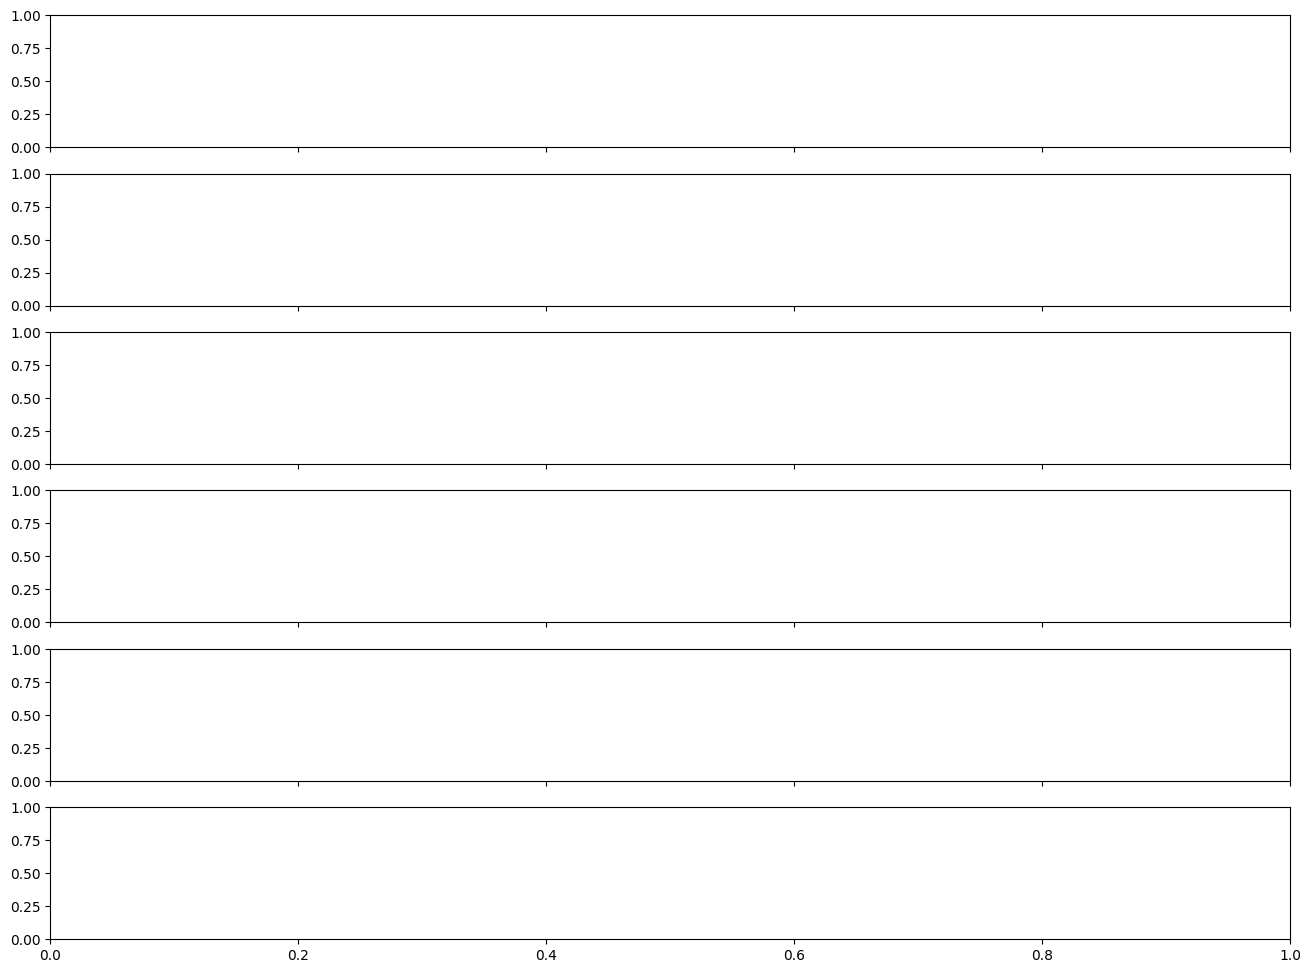

In [61]:
# plot zone 1 cumnsum
_, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(16,12), sharex=True)
prcp_ts = get_mean_timeseries(prcp_zone1)
t2_ts = get_mean_timeseries(t2_zone1)
q2_ts = get_mean_timeseries(q2_zone1)
et_ts = get_mean_timeseries(et_zone1)
ws10_ts = get_mean_timeseries(ws10_zone1)

plot_timeseries(
    ds=nino12index.sel(time=slice("2010-01-01", "2023-06-30")).value, 
    label="Niño 1.2 anomaly", 
    plot_type="line", 
    ax=ax1, 
    color="black",
    # edgecolor="black",
    # width=100,
)
ax1.set_ylabel("°C")

plot_timeseries(
    ds=prcp_ts['prcp'].rolling(time=30).mean(), 
    label='precipitation',
    plot_type='line', 
    ax=ax2,
)
ax2.set_ylabel("mm/day")

plot_timeseries(
    ds=t2_ts['t2'].rolling(time=30).mean() - 273.15, 
    label='2m temperature', 
    plot_type='line', 
    color="red",
    ax=ax3
)
ax3.set_ylabel("°C")

plot_timeseries(
    ds=q2_ts['q2'].rolling(time=30).mean(), 
    label='specific humidity', 
    plot_type='line',
    color="purple",
    ax=ax4
)
ax4.set_ylabel("g/kg")

plot_timeseries(
    ds=et_ts['et'].rolling(time=30).mean(), 
    label='act. evapotranspiration', 
    plot_type='line',
    color="green",
    ax=ax5,
)
ax5.set_ylabel("mm/day")

plot_timeseries(
    ds=ws10_ts['ws10'].rolling(time=30).mean(), 
    label='10m wind speed', 
    plot_type='line',
    color="black",
    ax=ax6,
)
ax6.set_ylabel("m/s")
plt.tight_layout()
plt.savefig("rc_trop_ls_MM_allvars_alltimes_zone1_cumsum.png")
plt.show()

In [ ]:
# plot zone 1
_, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(16,12), sharex=True)

plot_timeseries(
    ds=nino12index.sel(time=slice("2010-11-01", "2022-12-31")).value, 
    label="Niño 1.2 anomaly", 
    plot_type="bar", 
    ax=ax1, 
    color="black",
    edgecolor="black",
    width=100,
)
ax1.set_ylabel("°C")

plot_timeseries(
    ds=prcp_ts['prcp'].rolling(time=7).mean(), 
    label='precipitation',
    plot_type='line', 
    ax=ax2,
)
ax2.set_ylabel("mm/day")

plot_timeseries(
    ds=t2_ts['t2'].rolling(time=7).mean() - 273.15, 
    label='2m temperature', 
    plot_type='line', 
    color="red",
    ax=ax3
)
ax3.set_ylabel("°C")

plot_timeseries(
    ds=q2_ts['q2'].rolling(time=7).mean(), 
    label='specific humidity', 
    plot_type='line',
    color="purple",
    ax=ax4
)
ax4.set_ylabel("g/kg")

plot_timeseries(
    ds=et_ts['et'].rolling(time=7).mean(), 
    label='act. evapotranspiration', 
    plot_type='line',
    color="green",
    ax=ax5,
)
ax5.set_ylabel("mm/day")

plot_timeseries(
    ds=ws10_ts['ws10'].rolling(time=7).mean(), 
    label='10m wind speed', 
    plot_type='line',
    color="black",
    ax=ax6,
)
ax6.set_ylabel("m/s")
plt.tight_layout()
plt.savefig("rc_trop_ls_MM_allvars_alltimes_zone1.png")
plt.show()

In [ ]:
# plot zone2 cumnsum
_, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(16,12), sharex=True)
prcp_ts = get_mean_timeseries(prcp_zone2)
t2_ts = get_mean_timeseries(t2_zone2)
q2_ts = get_mean_timeseries(q2_zone2)
et_ts = get_mean_timeseries(et_zone2)
ws10_ts = get_mean_timeseries(ws10_zone2)

plot_timeseries(
    ds=nino12index.sel(time=slice("2010-10-01", "2022-12-31")).value, 
    label="Niño 1.2 anomaly", 
    plot_type="bar", 
    ax=ax1, 
    color="black",
    edgecolor="black",
    width=100,
)
ax1.set_ylabel("°C")

plot_timeseries(
    ds=prcp_ts['prcp'].rolling(time=7).mean().cumsum(), 
    label='precipitation',
    plot_type='line', 
    ax=ax2,
)
ax2.set_ylabel("mm/day")

plot_timeseries(
    ds=t2_ts['t2'].rolling(time=7).mean() - 273.15, 
    label='2m temperature', 
    plot_type='line', 
    color="red",
    ax=ax3
)
ax3.set_ylabel("°C")

plot_timeseries(
    ds=q2_ts['q2'].rolling(time=7).mean(), 
    label='specific humidity', 
    plot_type='line',
    color="purple",
    ax=ax4
)
ax4.set_ylabel("g/kg")

plot_timeseries(
    ds=et_ts['et'].rolling(time=7).mean().cumsum(), 
    label='act. evapotranspiration', 
    plot_type='line',
    color="green",
    ax=ax5,
)
ax5.set_ylabel("mm/day")

plot_timeseries(
    ds=ws10_ts['ws10'].rolling(time=7).mean(), 
    label='10m wind speed', 
    plot_type='line',
    color="black",
    ax=ax6,
)
ax6.set_ylabel("m/s")
plt.tight_layout()
plt.savefig("rc_trop_ls_MM_allvars_alltimes_zone2_cumsum.png")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


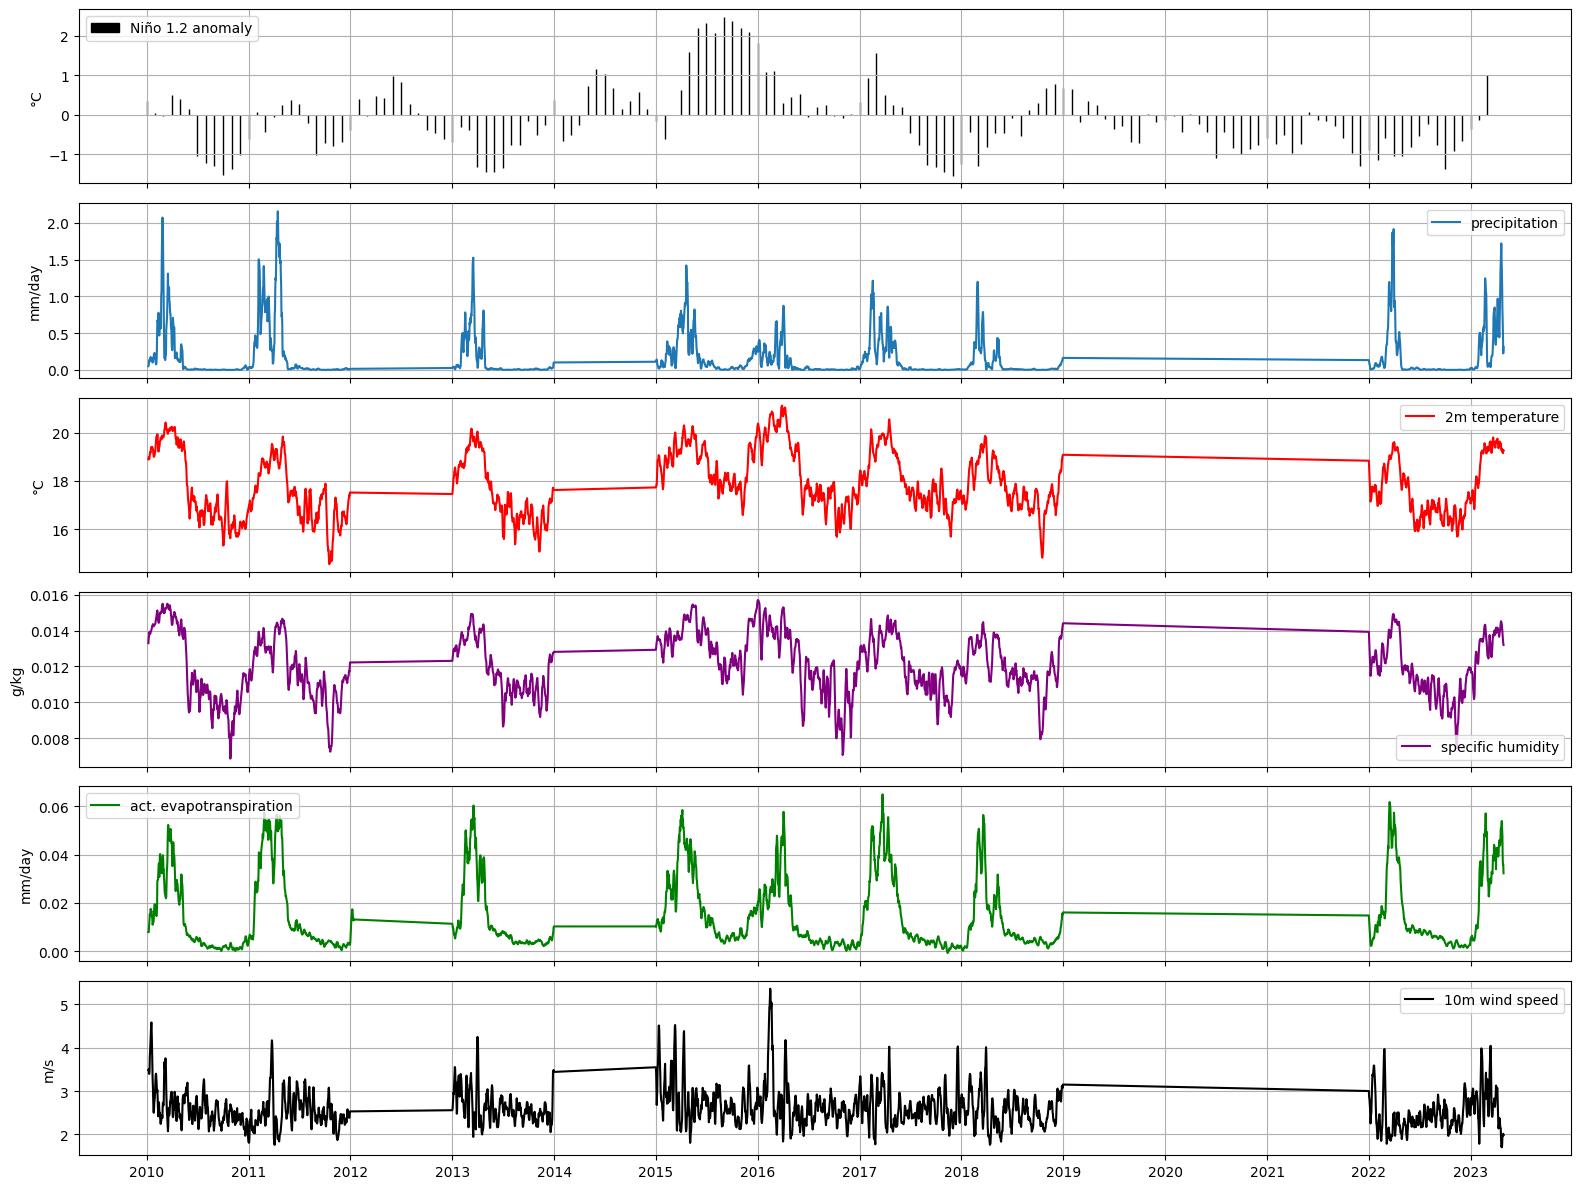

In [37]:
# plot zone2
_, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(16,12), sharex=True)
prcp_ts = get_mean_timeseries(prcp_zone3)
t2_ts = get_mean_timeseries(t2_zone3)
q2_ts = get_mean_timeseries(q2_zone3)
et_ts = get_mean_timeseries(et_zone3)
ws10_ts = get_mean_timeseries(ws10_zone3)

plot_timeseries(
    ds=nino12index.sel(time=slice("2010-01-01", "2023-05-31")).value, 
    label="Niño 1.2 anomaly", 
    plot_type="bar", 
    ax=ax1, 
    color="black",
    edgecolor="black",
    width=100,
)
ax1.set_ylabel("°C")

plot_timeseries(
    ds=prcp_ts['prcp'].rolling(time=7).mean(), 
    label='precipitation',
    plot_type='line', 
    ax=ax2,
)
ax2.set_ylabel("mm/day")

plot_timeseries(
    ds=t2_ts['t2'].rolling(time=7).mean() - 273.15, 
    label='2m temperature', 
    plot_type='line', 
    color="red",
    ax=ax3
)
ax3.set_ylabel("°C")

plot_timeseries(
    ds=q2_ts['q2'].rolling(time=7).mean(), 
    label='specific humidity', 
    plot_type='line',
    color="purple",
    ax=ax4
)
ax4.set_ylabel("g/kg")

plot_timeseries(
    ds=et_ts['et'].rolling(time=7).mean(), 
    label='act. evapotranspiration', 
    plot_type='line',
    color="green",
    ax=ax5,
)
ax5.set_ylabel("mm/day")

plot_timeseries(
    ds=ws10_ts['ws10'].rolling(time=7).mean(), 
    label='10m wind speed', 
    plot_type='line',
    color="black",
    ax=ax6,
)
ax6.set_ylabel("m/s")
plt.tight_layout()
plt.savefig("rc_trop_ls_MM_allvars_alltimes_zone2.png")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


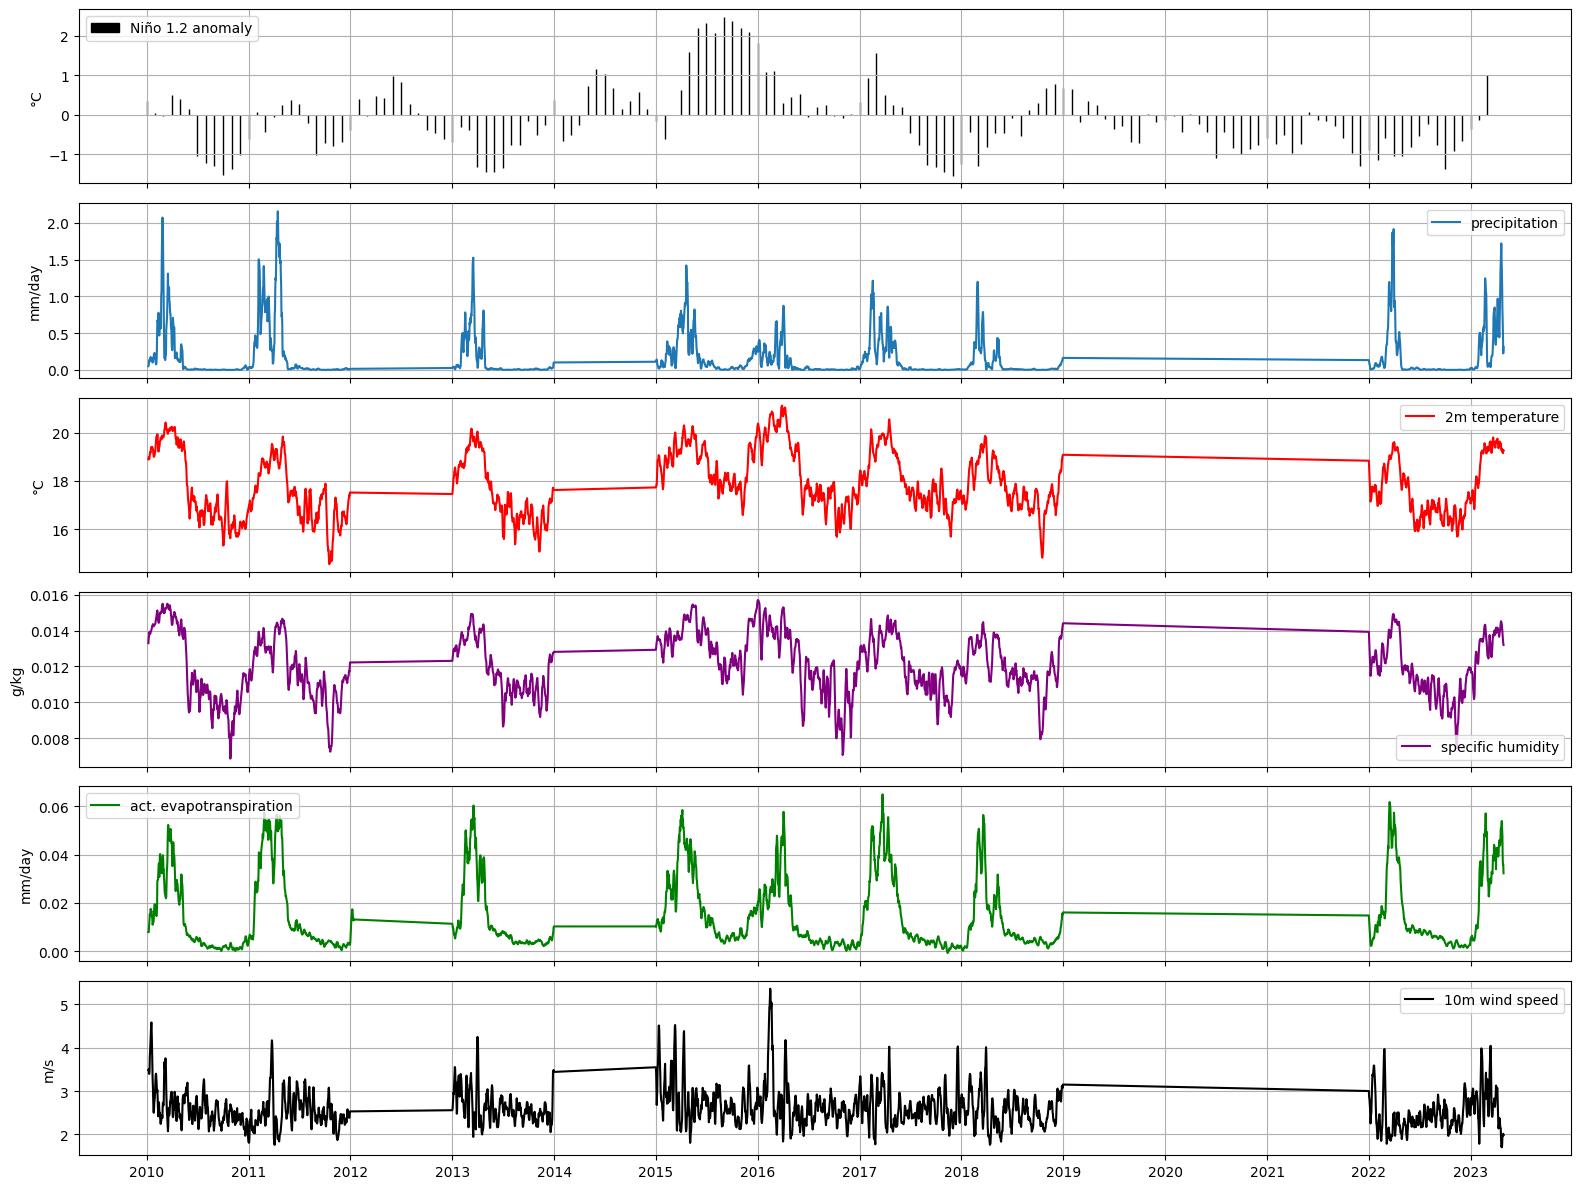

In [40]:
# plot zone3 cumsum
_, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(16,12), sharex=True)
prcp_ts = get_mean_timeseries(prcp_zone3)
t2_ts = get_mean_timeseries(t2_zone3)
q2_ts = get_mean_timeseries(q2_zone3)
et_ts = get_mean_timeseries(et_zone3)
ws10_ts = get_mean_timeseries(ws10_zone3)

plot_timeseries(
    ds=nino12index.sel(time=slice("2010-01-01", "2023-05-31")).value, 
    label="Niño 1.2 anomaly", 
    plot_type="bar", 
    ax=ax1, 
    color="black",
    edgecolor="black",
    width=100,
)
ax1.set_ylabel("°C")

plot_timeseries(
    ds=prcp_ts['prcp'].rolling(time=7).mean(), 
    label='precipitation',
    plot_type='line', 
    ax=ax2,
)
ax2.set_ylabel("mm/day")

plot_timeseries(
    ds=t2_ts['t2'].rolling(time=7).mean() - 273.15, 
    label='2m temperature', 
    plot_type='line', 
    color="red",
    ax=ax3
)
ax3.set_ylabel("°C")

plot_timeseries(
    ds=q2_ts['q2'].rolling(time=7).mean(), 
    label='specific humidity', 
    plot_type='line',
    color="purple",
    ax=ax4
)
ax4.set_ylabel("g/kg")

plot_timeseries(
    ds=et_ts['et'].rolling(time=7).mean(), 
    label='act. evapotranspiration', 
    plot_type='line',
    color="green",
    ax=ax5,
)
ax5.set_ylabel("mm/day")

plot_timeseries(
    ds=ws10_ts['ws10'].rolling(time=7).mean(), 
    label='10m wind speed', 
    plot_type='line',
    color="black",
    ax=ax6,
)
ax6.set_ylabel("m/s")
plt.tight_layout()
plt.savefig("rc_trop_ls_MM_allvars_alltimes_zone3_cumsum.png")
plt.show()

In [ ]:
# plot zone3
_, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(16,12), sharex=True)

plot_timeseries(
    ds=nino12index.sel(time=slice("2010-11-01", "2022-12-31")).value, 
    label="Niño 1.2 anomaly", 
    plot_type="bar", 
    ax=ax1, 
    color="black",
    edgecolor="black",
    width=100,
)
ax1.set_ylabel("°C")

plot_timeseries(
    ds=prcp_ts['prcp'].rolling(time=7).mean(), 
    label='precipitation',
    plot_type='line', 
    ax=ax2,
)
ax2.set_ylabel("mm/day")

plot_timeseries(
    ds=t2_ts['t2'].rolling(time=7).mean() - 273.15, 
    label='2m temperature', 
    plot_type='line', 
    color="red",
    ax=ax3
)
ax3.set_ylabel("°C")

plot_timeseries(
    ds=q2_ts['q2'].rolling(time=7).mean(), 
    label='specific humidity', 
    plot_type='line',
    color="purple",
    ax=ax4
)
ax4.set_ylabel("g/kg")

plot_timeseries(
    ds=et_ts['et'].rolling(time=7).mean(), 
    label='act. evapotranspiration', 
    plot_type='line',
    color="green",
    ax=ax5,
)
ax5.set_ylabel("mm/day")

plot_timeseries(
    ds=ws10_ts['ws10'].rolling(time=7).mean(), 
    label='10m wind speed', 
    plot_type='line',
    color="black",
    ax=ax6,
)
ax6.set_ylabel("m/s")
plt.tight_layout()
plt.savefig("rc_trop_ls_MM_allvars_alltimes_zone3.png")
plt.show()